<a href="https://colab.research.google.com/github/Tyluuus/MemotionAnalysis/blob/udpates/GSN_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GSN21Z Projekt 

Celem projektu będzie realizacja tasku B znajdującego się pod challengem Memotion na platformie Kaggle: https://www.kaggle.com/williamscott701/memotion-dataset-7k


Treść zadania: *Task B- Humor Classification: Given an Internet meme, the system has to identify the type of humor expressed. The categories are sarcastic, humorous, and offensive meme. If a meme does not fall under any of these categories, then it is marked as another meme. A meme can have more than one category.*





Dataset: W datasecie znajduje się 6992 memów pobranych z platformy reddit oraz oznaczonych z wykorzystaniem usługi Amazon Mechanical Turk. Oznaczenia znajdują się w pliku csv, który zawiera: 
1.   Nazwę pliku z memem
2.   Tekst uzyskany z wykorzystaniem OCR
3.   Tekst poprawiony
4.   Klasa humorystyczna
5.   Klasa sarkastyczna
6.   Klasa ofensywna
7.   Klasa motywacyjna


## Przygotowanie do użycia kodu

Podłączenie notatnika do dysku Google - potrzebne przy zapisie checkpoint'ów i słowników stanów 

In [32]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Sklonowanie repozytorium z githuba - pobranie plików składających się na dataset - zdjęć oraz pliku csv, pobierane są również pliki niezbędne do wczytania modelu sieci

In [33]:
!git clone https://github.com/Tyluuus/MemotionAnalysis.git

fatal: destination path 'MemotionAnalysis' already exists and is not an empty directory.


Instalacja pakietu `transformers` użytym przy klasyfikatorze BERT

In [34]:
pip install transformers

Importy wszystkich bibliotek wykorzystywanych w projekcie

In [35]:
#Imports

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import cv2
import time
import copy
import os
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms, datasets, models
from PIL import Image
from google.colab.patches import cv2_imshow
from torchtext.legacy.data import Dataset, Example, Field
from torchtext.legacy.data import BucketIterator
from transformers import BertModel
from transformers import BertTokenizer
from torch.optim import Adam
from tqdm import tqdm

Przełączenie na używanie GPU w projekcie jeżeli jest to możliwe

In [36]:
# Switch to using GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


Określenie:
- czy używany jest wytrenowany model, 
- czy wytrenowane modele powinny być zapisane,
- czy wykonany ma być _tranfer learning_,
- ścieżek do zapisu i odczytu modeli

In [37]:
# Use trained model variable
use_trained_model = False
save_model = True
image_model_continue_training = False
image_save_model_path = './drive/MyDrive/GSN_dataset/memotion_images_model_5_epoch_vgg19.pt'
text_save_model_path = './drive/MyDrive/GSN_dataset/memotion_text_model_bert_10_epochs.pt'
image_load_model_path = './MemotionAnalysis/memotion_images_model_1_epoch.pt'
text_load_model_path = './MemotionAnalysis/memotion_text_model_1_epoch.pt'
image_checkpoint_path = './drive/MyDrive/GSN_dataset/checkpoint.pt'
text_checkpoint_path = './drive/MyDrive/GSN_dataset/memotion_text_model_bert_10_epochs_checkpoint.pt'

Określenie liczby epok dla trenowania gałęzi tekstu i obrazu oraz rozmiaru batchy - _same_batch_size_ jest wielkością dla jednoczesnego trenowania obrazu i testu z tą samą wielkością batcha

In [38]:
text_epochs = 200 # 250
image_epochs = 5 # 20
text_batch_size = 2
image_batch_size = 16

same_batch_size = 32

Pobranie pretrenowanego modelu dla tekstu w razie potrzeby

In [39]:
# Download text model for 300 epochs
!gdown --id 1-9UMs4-3DO0acalwBUMf7rKHXBg1qV8n

Downloading...
From: https://drive.google.com/uc?id=1-9UMs4-3DO0acalwBUMf7rKHXBg1qV8n
To: /content/memotion_text_model_300_epoch.pt
100% 5.49M/5.49M [00:00<00:00, 20.8MB/s]


Domyślnie trenowanymi modelami są VGG16 oraz LSTM. Wybór innych modeli możliwy jest w sekcjach odpowiedzialnych za poszczególne gałęzie.

## Gałąź przetwarzania obrazu

### Utworzenie zbioru danych na podstawie danych z Kaggle

Wczytanie danych na zaimplementowanym obiekcie Dataset

In [40]:
class MyCustomDataset(Dataset):
    """
        Dataset designed to load data for Memotion Analisys Task from correspondig
        Kaggle and assign weights for classes from task csv file
    """
    def __init__(self, csv_path, low_data_mode=False, debug=False):
        """
        Args:
          csv_path (string): path to csv file with data 
          low_data_mode (boolean): low data mode for testing 
          debug (boolean): enable debug options
        """
        # If system is in debug mode
        self.debug = debug


        # Read the csv_file
        if low_data_mode==True:
          self.data_info = pd.read_csv(csv_path, header = 6952)
        else:
          self.data_info = pd.read_csv(csv_path, header = 3)

        # Column containing image names
        self.image_arr = np.asarray(self.data_info.iloc[:, 1])

        # Columns containing emotions classification
        self.humour_arr = np.asarray(self.data_info.iloc[:, 4])
        self.sarcasm_arr = np.asarray(self.data_info.iloc[:, 5])
        self.offensive_arr = np.asarray(self.data_info.iloc[:, 6])
        self.motivational_arr = np.asarray(self.data_info.iloc[:, 7])
        


        # Transforms performed on loaded image
        self.data_transforms = transforms.Compose([
                                      transforms.Resize((224, 224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        # Array with class vectors for each image
        self.labels = []

        # Mapping word classification to 4 numeric classes
        for index in range(len(self.humour_arr)):
          humour_value = class_humour_weights[self.humour_arr[index]]
          sarcasm_value = class_sarcasm_weights[self.sarcasm_arr[index]]
          offensive_value = class_offensive_weights[self.offensive_arr[index]]
          motivational_value = class_motivational_weights[self.motivational_arr[index]]

          if humour_value > sarcasm_value:
            if humour_value > offensive_value:
              if humour_value > motivational_value:
                var = 0
              else:
                var = 3 
            else:
              if offensive_value > motivational_value:
                var = 2
              else: 
                var = 3
          else:
            if sarcasm_value > offensive_value:
              if sarcasm_value > motivational_value:
                var = 1
              else:
                var = 3
            else: 
              if offensive_value > motivational_value: 
                var = 2
              else:
                var = 3

          # Creating class vector
          lab = [0.0, 0.0, 0.0, 0.0]
          lab[var] = 1.0
          
          # Adding new image class vector to labels array
          self.labels.append(lab) 

        # Calculate of dataset
        self.data_len = len(self.data_info.index)
        
        # Set correct path to images
        self.image_arr = images_dir + self.image_arr

        
    def __getitem__(self, index):
        """
        Args:
          index (int): index of item to get  

        Returns:
          Tuple of image, text and class vector as tensors
        """
        img_as_img = None
        single_image_name = None


        try:
          # Get image name from pandas df
          single_image_name = self.image_arr[index]

          # # Open image with PIL and convert to RGB image
          img = Image.open(single_image_name).convert('RGB')
          if self.debug==True:
            print('1:', img)

          # Transform image and convert to tensor
          img_as_tensor = self.data_transforms(img)

          if self.debug==True:
            print('2:', img_as_tensor)

          # Get class vector of the image from labels array
          img_label = self.labels[index]

          if self.debug==True:
            print('3:',img_label)

          # Convert class vector to tensor
          img_label = torch.as_tensor(img_label)
          
          if self.debug==True:
            print('4:',img_label)

          return (img_as_tensor, img_label)

        except:
          print("Image loading error for:",single_image_name)
          return ('ERROR', torch.tensor([-1]))

    def __len__(self):
        return self.data_len

Mapowanie opisów z pliku csv na liczby zgodnie z wagą jaką reprezentują dla danego odczucia

In [41]:
# Dictionaries for mapping word classification
class_humour_weights = {"hilarious": 3, "not_funny": 0, "very_funny": 2, "funny": 1}
class_sarcasm_weights = {"general": 1, "not_sarcastic": 0, "twisted_meaning": 2, "very_twisted": 3}
class_offensive_weights = {"not_offensive": 0, "slight": 1, "very_offensive": 2, "hateful_offensive": 3}
class_motivational_weights = {"not_motivational": 0, "motivational": 1}

# Directory containing images
images_dir = "./MemotionAnalysis/images/"

Wczytanie danych oraz utworzenie z nich dataloader'a

In [42]:
# Loading images into custom dataset
dataset = MyCustomDataset('MemotionAnalysis/labels.csv', low_data_mode=False)

# Loading dataset into DataLoader and setting batch_size
b_size = same_batch_size if use_trained_model else image_batch_size
dataloader = torch.utils.data.DataLoader(dataset, batch_size=b_size, shuffle=False, num_workers=1)
dataset_size = len(dataloader)

Sprawdzenie wczytywanych danych

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


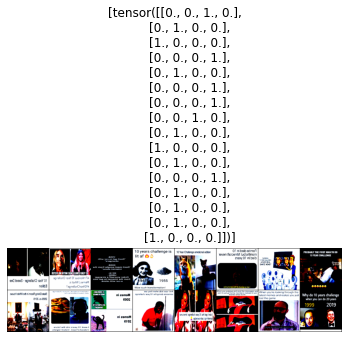

In [43]:
# Check loaded data

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[classes])

# Get a batch of training data
inputs, classes = next(iter(dataloader))
show_databatch(inputs, classes)

### Definicja modelu i uczenie

Wybór modelu obrazu z dwóch przetestowanych modeli VGG16 i VGG19

In [44]:
# avaliable models: vgg_16, vgg_19
image_model_type = 'vgg_16' # 'vgg_19'

Pobranie słownika stanu dla pretrenowanego VGG 16

In [45]:
# Downloading pretrained vgg16

!gdown --id 1f3iqJY2NDTsJP2_BFmtk5WtcfAW9nwdl

Downloading...
From: https://drive.google.com/uc?id=1f3iqJY2NDTsJP2_BFmtk5WtcfAW9nwdl
To: /content/vgg16_bn.pth
100% 554M/554M [00:07<00:00, 72.0MB/s]


Zainicjowanie modelu VGG w wybranej wersji

In [46]:
vgg = None

if image_model_type == 'vgg_16':
  vgg = models.vgg16_bn()
  vgg.load_state_dict(torch.load("/content/vgg16_bn.pth")) 
  print("Used model: VGG16")
elif image_model_type == 'vgg_19':
  vgg = models.vgg19_bn()
  print("Used model: VGG19")

Used model: VGG16


Określenie klasy _custom_vgg_, która pozwala odtworzyć architekturę baseline ze 
źródła: w porównaniu z bazowym VGG zmieniony jest klasyfikator, po wyciągnięciu
feature'ów przeprowadzany jest pooling, nastepnie wynik przekazywany jest do warstwy fully connected i poddawany funkcji sigmoid - wynikiem jest wektor czteroelementowy.

In [47]:
# if use_trained_model==False:

  # Class with own modification of VGG16 architecture - classifier was changed - 
  # after getting features from image there is pooling layer, next results are flattened and feed to fully connected layer with output number = 4
  # at the end sigmoid function is used

class custom_vgg(nn.Module):
    """
        Custom vgg implementation as described in baseline in in Memotion Analisys 
        task summary (https://arxiv.org/pdf/2008.03781.pdf)
    """
    def __init__(self, model):
        """
            Args:
                model: base VGG model downloaded from source
        """
        super(custom_vgg, self).__init__()

        self.features = list(model.features)
        self.features = nn.Sequential(*self.features)
        self.pooling = model.avgpool
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(in_features=25088, out_features=4, bias=True)
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        """
            Args:
                x: object to perform learning on
        """
        out = self.features(x)
        out = self.pooling(out)
        out = self.flatten(out)
        out = self.fc(out)
        out = self.sigm(out)
        return out


Inicjalizacja modelu _custom_vgg_ na wgranym wcześniej modelu VGG

In [48]:
# Loading custiom VGG16 from loaded, pretrained VGG16 model
vgg = custom_vgg(vgg)

# if use_trained_model==True:
#   vgg16.load_state_dict(torch.load('/content/drive/MyDrive/GSN_dataset/memotion_images_model.pt'))

Przełączenie na korzystanie z GPU jeżeli to możliwe oraz określenie krytrium, optimizera i learning rate schedulera dla pętli uczenia

In [49]:
# Set VGG to run on GPU
if use_gpu:
    vgg.cuda()
    
criterion = nn.BCELoss()

# Define optimizer and LR Scheduler for training
optimizer_ft = optim.SGD(vgg.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Definicja słownika danych dla obliczania makro F1 wraz z funkcjami operującymi na słowniku

In [50]:
# F1 score calculating for image
image_f1_data = {
    0: {
        "true_positive": 0.0,
        "false_positive": 0.0,
        "false_negative": 0.0
    },
    1: {
        "true_positive": 0.0,
        "false_positive": 0.0,
        "false_negative": 0.0
    },
    2: {
        "true_positive": 0.0,
        "false_positive": 0.0,
        "false_negative": 0.0
    },
    3: {
        "true_positive": 0.0,
        "false_positive": 0.0,
        "false_negative": 0.0
    }
}

def clear_image_f1_data():
    """
        Clearnig realted F1 data dict
    """
    for i in range(4):
        image_f1_data[i]["true_positive"] = 0.0
        image_f1_data[i]["false_positive"] = 0.0
        image_f1_data[i]["false_negative"] = 0.0

def update_image_f1_data(preditions: list, labels: list):
    """
        Updating F1 data dict with list of predicted class and actual labels
        Args:
            predictions (list): list of predicted classes with data in range 0-3
            labels (list): list of actual classes with data in range 0-3
    """
    for i in range(len(preditions)):
        if(preditions[i] == labels[i]):
            image_f1_data[labels[i]]["true_positive"] += 1.0
        else:
            image_f1_data[labels[i]]["false_positive"] += 1.0
            image_f1_data[preditions[i]]["false_negative"] += 1.0
                

def calculate_image_f1_for_class(class_number: int):
    """
        Calculating F1 for given class number based on data in F1 data dict
        Args:
            class_number(int): Class number of which F1 will be calculated
    """
    precision_divider = image_f1_data[class_number]["true_positive"]+image_f1_data[class_number]["false_positive"]
    precision = (image_f1_data[class_number]["true_positive"] / precision_divider) if precision_divider > 0 else 0
    recall_divider = image_f1_data[class_number]["true_positive"]+image_f1_data[class_number]["false_negative"]
    recall = (image_f1_data[class_number]["true_positive"] / recall_divider) if recall_divider > 0 else 0
    #print(f"Precision: {precision} , Recall: {recall} ")
    return (2 * (precision * recall) / (precision + recall)) if (precision + recall) > 0 else 0

def calculate_image_macro_f1():
    """
        Calculates macro F1 based on F1 score of each class - based on `calculate_image_f1_for_class`
        function
    """
    macro_f1 = 0.0
    for i in range(4):
        macro_f1 += calculate_image_f1_for_class(i)
    return macro_f1/4

Definicja funkcji pomocniczej konwertującej klasy jako indeksy w macierzy do listy z indeksami na których występują dane, przykład:
```
[[1, 0, 0, 0],
 [0, 0, 1, 0],
 [0, 1, 0, 0],  
 [0, 0, 0, 1]]  = [0, 2, 1 ,3]
```
Funckja potrzebna jest przy uczeniu

In [51]:
def classes_convert(classes):
    """
        Converts matrix of indices (classes) to list with indices of value ex:
        [[1, 0, 0, 0],
         [0, 0, 1, 0],
         [0, 1, 0, 0],  
         [0, 0, 0, 1]]  = [0, 2, 1 ,3]
        Args:
            classes (list): list of lists for classes which will be converted
    """
    clas = []
    for element in range(len(classes)):
        var = classes[element]
        for index in range(len(var)):
            if var[index]==1:
                clas.append(index)
    return torch.tensor(clas)

Funckja służąca do wczytania słownika stanów z pliku zewnętrznego, używana przy _transfer_learning_ oraz użyciu gotowych modeli

In [52]:
def load_checkpoint(model, optimizer, filename):
    """
        Load pretrained data to model and optimizer from file
        Args:
            model (nn.Model): model object to which data will be loaded
            optimizer (torch.optim): optimizer obcject to which data will be loaded
            filename (string): file from which data will be loaded
    """
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}'"
                  .format(filename))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer

Definicja funkcji uczącej dla gałęzi obrazu dla VGG

In [53]:
# Defining training model
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=1, debug=False):
    """
        Args:
            vgg (nn.Model): Neural Network model to traing
            criterion (nn.LossFunction): Loss Function 
            optimizer (torch.optim): Optimalization Function
            scheduler (torch.optim.lr_scheduler): Learning Rate Scheduler
            num_epochs (int): Number of training epochs
            debug (boolean): Debug mode toogle
    """

    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloader)
    val_batches = len(dataloader)
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        target_true = 0
        predicted_true = 0
        correct_true = 0
        
        vgg.train(True)
        clear_image_f1_data()
        for inputs, classes in iter(dataloader):
            if use_gpu:
                sample, clas = Variable(inputs.cuda()), Variable(classes.cuda())
            else:
                sample, clas = Variable(inputs), Variable(classes)
            
            # addressing batch labels to list
            batch_labels = []
            for row in clas.data:
              for i in range(len(row)):
                if row[i] == 1:
                  batch_labels.append(i)
            
            if use_gpu:
              batch_labels = torch.tensor(batch_labels).cuda()
            else:
              batch_labels = torch.tensor(batch_labels)
            
            optimizer.zero_grad()
            outputs = vgg(sample)

            if debug==True:
              print(outputs)
              print(clas)

            _, preds = torch.max(outputs.data, -1)
            loss = criterion(outputs, clas)
            
            loss.backward()
            optimizer.step()

            update_image_f1_data(preds.squeeze().tolist(), batch_labels.squeeze().tolist())
            
            del sample, clas, outputs, preds
            torch.cuda.empty_cache()
        
        epoch_train_macro_f1 = calculate_image_macro_f1()
        
        vgg.train(False)
        vgg.eval()
        clear_image_f1_data()    
        for inputs, classes in iter(dataloader):
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(classes.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(classes)

            # addressing batch labels to list
            batch_labels = []
            for row in labels.data:
              for i in range(len(row)):
                if row[i] == 1:
                  batch_labels.append(i)
            
            if use_gpu:
              batch_labels = torch.tensor(batch_labels).cuda()
            else:
              batch_labels = torch.tensor(batch_labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            # Prediction
            _, preds = torch.max(outputs.data, 1)
            if debug==True:
              print("Preds: ",preds)
            loss = criterion(outputs, labels)
            if debug==True:
              print("[1]Classes shape: ",classes.shape)
              print("[1]Classes: ",classes)

            classes = classes_convert(classes)
            if debug==True:
              print("[2]Classes: ",classes.shape)
              print("[2]Classes: ",classes)
            
            update_image_f1_data(preds.squeeze().tolist(), batch_labels.squeeze().tolist())
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        epoch_val_macro_f1 = calculate_image_macro_f1()

        print()
        print("Epoch {} result: ".format(epoch))
        print("F1 score: {:.4f} (train), {:.4f} (val)".format(epoch_train_macro_f1, epoch_val_macro_f1))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg

Uruchomienie uczenia w odpowiedniej wersji zgodnej z określonymi na początku założeniami tj. trenowanie od początku albo _transfer learning_ oraz zapisywanie modelu, gdy zostało to określone

In [54]:
if use_trained_model==False and image_model_continue_training == False:
  vgg = train_model(vgg, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=image_epochs, debug=False)
  if save_model:
    torch.save(vgg.state_dict(), image_save_model_path)
    print("Image model saved")
    checkpoint = {'state_dict': vgg.state_dict(), 'optimizer': optimizer_ft.state_dict()}
    torch.save(checkpoint, image_checkpoint_path)
    print("Checkpoint saved")

elif use_trained_model==False and image_model_continue_training == True:
  
  checkpoint_model, optimizer = load_checkpoint(vgg, optimizer_ft,image_checkpoint_path)
  checkpoint_model = checkpoint_model.cuda()
  lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  for state in optimizer.state.values():
    for k,v in state.items():
      if isinstance(v, torch.Tensor):
        state[k] = v.cuda()
        
  vgg = train_model(checkpoint_model, criterion, optimizer, lr_scheduler, num_epochs=image_epochs, debug=False)
  if save_model:
    torch.save(vgg.state_dict(), image_save_model_path)
    print("Image model saved")
    checkpoint = {'state_dict': vgg.state_dict(), 'optimizer': optimizer.state_dict()}
    torch.save(checkpoint, image_checkpoint_path)
    print("Checkpoint saved")
    

Epoch 0/5
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



Epoch 0 result: 
F1 score: 0.2217 (train), 0.2062 (val)
----------

Epoch 1/5
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Image loading error for: ./MemotionAnalysis/images/image_6774.jpg


KeyboardInterrupt: ignored

## Gałąź przekształcania tekstu

Dla przetwarzania tekstu możliwe jest użycie dwóch klasyfikatorów: (Bi)LSTM lub BERT

### Utworzenie zbioru danych dla tekstu na podstawie zbioru z Kaggle

Utworzenie obiektów Field na podstawie tekstu wyciągnietego ze Dataset'u określanego w gałęzi obrazu. Tekst poddawany jest embeddingowi z użyciem GloVe 100d.

In [55]:
# Text preprocessing

meme_text = dataset.data_info.iloc[:, 3]

raw_df = []

for i in range(len(meme_text)):
    raw_df.append([str(meme_text[i]), dataset.labels[i]])

df = pd.DataFrame(raw_df[:-3], columns=['text', 'label'])

text_field = Field(
    sequential=True,
    tokenize='basic_english', 
    fix_length=64,
    lower=True
)
label_field = Field(sequential=False, use_vocab=False)
# prepocess
preprocessed_text = df['text'].apply(
    lambda x: text_field.preprocess(x)
)
# load fastext simple embedding with 100d
text_field.build_vocab(
    preprocessed_text, 
    vectors='glove.6B.100d'
)

Utworzenie zbiorów danych - uczącego i walidacyjnego - na podstawie wgranych DataFrame z biblioteki `pandas`

In [56]:
class DataFrameDataset(Dataset):
    """
        Dataset created drom pandas DataFrame with text data from Kaggle for 
        Memotion Analisys task
    """
    def __init__(self, df: pd.DataFrame, fields: list):
        super(DataFrameDataset, self).__init__(
            [
                Example.fromlist(list(r), fields) for i, r in df.iterrows()
            ], 
            fields
        )

train_dataset, test_dataset = DataFrameDataset(
    df=df, 
    fields=(
        ('text', text_field),
        ('label', label_field)
    )
).split(split_ratio=0.85)

b_size = same_batch_size if use_trained_model else text_batch_size

train_iter, test_iter = BucketIterator.splits(
    datasets=(train_dataset, test_dataset), 
    batch_sizes=(b_size, b_size),
    sort=False
)

Definicja słownika danych dla obliczania makro F1 wraz z funkcjami operującymi na słowniku

In [62]:
text_f1_data = {
    0: {
        "true_positive": 0.0,
        "false_positive": 0.0,
        "false_negative": 0.0
    },
    1: {
        "true_positive": 0.0,
        "false_positive": 0.0,
        "false_negative": 0.0
    },
    2: {
        "true_positive": 0.0,
        "false_positive": 0.0,
        "false_negative": 0.0
    },
    3: {
        "true_positive": 0.0,
        "false_positive": 0.0,
        "false_negative": 0.0
    }
}

def clear_text_f1_data():
    """
        Clearnig realted F1 data dict
    """
    for i in range(4):
        text_f1_data[i]["true_positive"] = 0.0
        text_f1_data[i]["false_positive"] = 0.0
        text_f1_data[i]["false_negative"] = 0.0

def update_text_f1_data(preditions: list, labels: list):
    """
        Updating F1 data dict with list of predicted class and actual labels
        Args:
            predictions (list): list of predicted classes with data in range 0-3
            labels (list): list of actual classes with data in range 0-3
    """
    if type(preditions) is int:
      preditions = [preditions]
    if type(labels) is int:
      labels = [labels]
    for i in range(min(len(preditions), len(labels))):
        if(preditions[i] == labels[i]):
            text_f1_data[labels[i]]["true_positive"] += 1.0
        else:
            text_f1_data[labels[i]]["false_positive"] += 1.0
            text_f1_data[preditions[i]]["false_negative"] += 1.0
                

def calculate_text_f1_for_class(class_number: int):
    """
        Calculating F1 for given class number based on data in F1 data dict
        Args:
            class_number(int): Class number of which F1 will be calculated
    """
    if text_f1_data[class_number]["true_positive"] == 0:
      return 0
    precision = text_f1_data[class_number]["true_positive"] / (text_f1_data[class_number]["true_positive"]+text_f1_data[class_number]["false_positive"])
    recall = text_f1_data[class_number]["true_positive"] / (text_f1_data[class_number]["true_positive"]+text_f1_data[class_number]["false_negative"])
    # print(f"Precision: {precision} , Recall: {recall} ")
    return 2 * (precision * recall) / (precision + recall)

def calculate_text_macro_f1():
    """
        Calculates macro F1 based on F1 score of each class - based on `calculate_image_f1_for_class`
        function
    """
    macro_f1 = 0.0
    for i in range(4):
      macro_f1 += calculate_text_f1_for_class(i)
    return macro_f1/4

Funkcja pomocnicza mająca na celu poprawne zapisanie klas poprzez znalezienie maksymalnego prawdopodobieństwa zwróconego przez klasyfikator. Używana przy uczeniu tekstu w klasyfikatorze LSTM.

In [63]:
def text_classes_convert(classes):
    """
        Maps output max from probabilities to binary classes, ex.
        [0.6, 0.4, 0.3, 0.3] = [1, 0, 0, 0]
    """
    y = classes
    # Actual conversion using y elements as index 
    M = np.zeros(len(y))

    for i in range(len(y)):
        M[i]=torch.argmax(y[i])
    return torch.tensor(M)

### BERT

Ze względu na odmienne podejście w klasyfikatorze BERT zbiór danych dla niego tworzony jest osobno, również na podstawie DataField z biblioteki `pandas`

In [64]:
class BertDataset(Dataset):
    """
        Dataset for BERT classificator with text data from Kaggle for 
        Memotion Analisys task
    """
    def __init__(self, df):
        """
            Args:
            df - pandas DataFrame object 
        """
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
        self.labels = [np.argmax(l) for l in df['label']]
        self.data = [self.tokenizer(t, 
                            padding="max_length", max_length=128,
                            truncation=True, return_tensors="pt") for t in df['text']]

    def classes(self):
        """
            Get all the classes for classifier
        """
        return self.labels

    def __len__(self):
        """
            Get all the classes len for classifier
        """
        return len(self.labels)

    def get_batch_labels(self, idx):
        """
            Fetch a batch of labels
        """
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        """
            Fetch a batch of inputs
        """
        return self.data[idx]

    def __getitem__(self, idx):
        """
            Fetch a batch of inputs and correspoding labels
            Returns:
                Tuple of batch of text and batch of correspoding labels
        """
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

Inicjacja zbiorów testowego, walidacyjnego i uczącego, sprawdzenie długości zbiorów

In [65]:
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

5585 698 699


Definicja klasyfikatora BERT

In [66]:
class BertClassifier(nn.Module):
    """
        BERT classifier baser on PyTorch BERT clasifier, using pretrained
        data
    """
    def __init__(self, dropout=0.5):
        """
            Args:
                dropout: dropout rate
        """
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 4)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        """
            Perform train on given input
            Args:
                input_id (int) - input id on which learning should be performed
                mask - attention mask which will be used in training
            Returns:
                tensor of predicted classes
        """
        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

Definicja funkcji uczenia i evaluacji modelu BERT

In [67]:
# Text model train - BERT

def train_bert(model, train_data, val_data, lr, epochs):
    """
        Training BERT model and saving if global config is set to
        Args:
            model (nn.Model) - BertModel to train
            train_data (Dataset) - dataset with data to train
            val_Set (Dataset) - dataset to evaluate
            lr (float) - learning rate
            epochs (int) - number of epochs
    """
    train, val = BertDataset(train_data), BertDataset(val_data)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr = lr)
    
    if use_cuda:
            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):
            total_acc_train = 0
            total_loss_train = 0
            clear_text_f1_data()
            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc
                update_text_f1_data(output.argmax(dim=1).tolist(), train_label.squeeze().tolist())
                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0
            epoch_train_macro_f1 = calculate_text_macro_f1()
            clear_text_f1_data()
            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    update_text_f1_data(output.argmax(dim=1).tolist(), val_label.squeeze().tolist())
                    total_acc_val += acc
            epoch_val_macro_f1 = calculate_text_macro_f1()
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f} \
                | Train macro F1: {epoch_train_macro_f1} \
                | Val macro F1: {epoch_val_macro_f1} \
            ')
            if save_model:
                torch.save(model.state_dict(), text_save_model_path)
                print("Image model saved")
                checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
                torch.save(checkpoint, text_checkpoint_path)
                print("Checkpoint saved")

def evaluate_bert(model, test_data):
    """
        Evaluating BERT model on given set
        Args:
            model (nn.Model) - BERT model
            test_dataset (Dataset) - dataset to evaluate BERT on
    """

    test = BertDataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    clear_text_f1_data()
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
              update_text_f1_data(output.argmax(dim=1).tolist(), test_label.squeeze().tolist())
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    print("F1 score: {:.4f}".format(calculate_text_macro_f1()))

Uruchomienie trenowania modelu BERT

In [68]:
bert_model = BertClassifier()
LR = 1e-6
              
train_bert(bert_model, df_train, df_val, LR, text_epochs)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

KeyboardInterrupt: ignored

Ewaluacja modelu BERT

In [ ]:
evaluate_bert(bert_model, df_test)

### LSTM

Określenie modelu LSTM

In [69]:
# if use_trained_model==False:

class ModelParam(object):
    """
        Class with parameters for TextModel
    """
    def __init__(self, param_dict: dict = dict()):
        """
            Args:
                param_dict - dict with data for TextModel, possible fields:
                    - input_size (batch size),
                    - vocab_size (size of vocabulary),
                    - embedding_size (same as in embedding),
                    - target_dim (final prediction size)
        """
        self.input_size = param_dict.get('input_size', 0)
        self.vocab_size = param_dict.get('vocab_size')
        self.embedding_dim = param_dict.get('embedding_dim', 100)
        self.target_dim = param_dict.get('target_dim')
        
class TextModel(nn.Module):
    """
        Class with LSTM model as described in baseline in in Memotion Analisys 
        task summary (https://arxiv.org/pdf/2008.03781.pdf)
    """
    def __init__(self, model_param: ModelParam):
        """
            Args:
                model_param (ModelParam) - parameters for model in ModelParam class wrapper
        """
        super().__init__()
        self.embedding = nn.Embedding(model_param.vocab_size, model_param.embedding_dim)
        self.conv = nn.Conv1d(64, 100, 4)
        self.max_pool = nn.MaxPool1d(2)
        self.lstm = nn.LSTM(48, 16, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(in_features=3200, out_features=4, bias=True)
        self.sigm = nn.Sigmoid()
        self.flatt = nn.Flatten()

    def forward(self, x):
        """
            Perform training on element x
            Args:
                x - elem to train on
            Returns:
                tensor of predictions
        """
        features = self.embedding(x)
        features = F.relu(features)
        features = self.conv(features)
        features = self.max_pool(features)
        features, hidden = self.lstm(features)
        features = self.flatt(features)
        features = self.fc(features)
        features = self.sigm(features)
        return features

Trenowanie modelu LSTM

In [70]:
# Text model train - LSTM

if use_trained_model==False:
    model_param = ModelParam(
    param_dict=dict(
        vocab_size=len(text_field.vocab),
        input_size=64,
        embedding_dim=100,
        target_dim=4
        )
    )
    train_text_model = TextModel(model_param).cuda()
    
    loss_function = nn.BCELoss()
    optimizer = optim.Adam(train_text_model.parameters(), lr=0.0002)
    best_model_wts = copy.deepcopy(train_text_model.state_dict())
    best_val_f1 = -1
    epoch_count = 0
    losses = []
    val_losses = []
    val_acc = []
    for epoch in range(text_epochs):
        train_text_model.train()
        clear_text_f1_data()
        b_num = 0
        epoch_num = 0
        epoch_losses = []
        k = 0
        for batch in train_iter:
            optimizer.zero_grad()
            prediction = train_text_model(batch.text.T.cuda())
            batch_label = batch.label.to(torch.float)
            labels = text_classes_convert(batch_label).cuda()
            preds = torch.flatten(torch.max(prediction, 1)[1]).float().cuda()
            # print(prediction.shape)
            # print(batch.label.shape)
            loss = loss_function(torch.squeeze(prediction), torch.squeeze(batch.label.to(torch.float)).cuda())
            #update_text_f1_data(preds.squeeze().tolist(), labels.squeeze().tolist())
            # print(prediction)
            # print(batch.label)
            # print(preds)
            # print(labels)
            update_text_f1_data(preds.tolist(), labels.tolist())
            loss.backward()
            epoch_losses.append(loss.item())
            optimizer.step()
            k = k+1
        
        losses.append(sum(epoch_losses)/k)
        train_text_macro_f1 = calculate_text_macro_f1()
        
        train_text_model.eval()
        clear_text_f1_data()
        val_epoch_losses = []
        k = 0
        total_acc_val = 0
        
        test_iter_elements_number = 0
        for batch in test_iter:
            with torch.no_grad():
                optimizer.zero_grad()
                prediction = train_text_model(batch.text.T.cuda())
                batch.label = batch.label.to(torch.float)
                labels = text_classes_convert(batch.label).cuda()
                # preds = torch.flatten(torch.max(prediction, 1)[1]).float().cuda()
                _, preds = torch.max(prediction, 1)
                # print(preds)
                # print(preds2)
                loss = loss_function(torch.squeeze(prediction), torch.squeeze(batch.label.to(torch.float)).cuda())
                #update_text_f1_data(preds.squeeze().tolist(), labels.squeeze().tolist())
                # print(prediction)
                # print(batch.label)
                # print(preds)
                # print(labels)
                
                test_iter_elements_number += len(labels)
                acc = (preds == labels).sum().item()
                # print(acc)
                # print(loss)
                total_acc_val += acc
                val_epoch_losses.append(loss.item())
                update_text_f1_data(preds.tolist(), labels.tolist())
                k = k+1

        # print(total_acc_val)
        # print(test_iter_elements_number)
        val_acc.append(total_acc_val / test_iter_elements_number)
        val_losses.append(sum(val_epoch_losses)/k)
        val_text_macro_f1 = calculate_text_macro_f1()
        if val_text_macro_f1 > best_val_f1:
            best_val_f1 = val_text_macro_f1
            best_model_wts = copy.deepcopy(train_text_model.state_dict())
        else :
            train_text_model.load_state_dict(best_model_wts)
        print()
        print("Epoch {} result: ".format(epoch))
        print("F1 score: {:.4f} (train), {:.4f} (val)".format(train_text_macro_f1, val_text_macro_f1))
        print('-' * 10)
        print()
    print(f"Best val f1 score: {best_val_f1}")
    if save_model:
        torch.save(best_model_wts, text_save_model_path)
        print("Text model saved")

KeyboardInterrupt: ignored

## Testowanie wytrenowanych modeli

Wczytanie danych do testowania (w wypadku jednoczesnego trenowania i testowania wczytywany jest drugi raz ten sam zbiór)

In [74]:
class TestDataset(Dataset):
    """
        Dataset with data for Memotion Analisys Kaggle for tests
    """
    def __init__(self, csv_path, low_data_mode=False, debug=False):
        """
            Args:
            csv_path (string): path to csv file with data 
            low_data_mode (boolean): low data mode for testing 
            debug (boolean): enable debug options
        """
        self.debug = debug
        # Read the csv_file
        if low_data_mode==True:
          self.data_info = pd.read_csv(csv_path, header = 6952)
        else:
          self.data_info = pd.read_csv(csv_path, header = 3)

        # Column containing image names
        self.image_arr = np.asarray(self.data_info.iloc[:, 1])
        # Columns containing emotions classification
        self.humour_arr = np.asarray(self.data_info.iloc[:, 4])
        self.sarcasm_arr = np.asarray(self.data_info.iloc[:, 5])
        self.offensive_arr = np.asarray(self.data_info.iloc[:, 6])
        self.motivational_arr = np.asarray(self.data_info.iloc[:, 7])
        
        # Transforms performed on loaded image
        self.data_transforms = transforms.Compose([
                                      transforms.Resize((224, 224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        # Array with class vectors for each image
        self.labels = []
        self.text_arr = self.data_info.iloc[:, 3]
        raw_df = []

        for i in range(len(self.text_arr)):
            raw_df.append([str(self.text_arr[i])])
        self.df = pd.DataFrame(raw_df[:-2], columns=['text'])

        self.text_field = Field(
            sequential=True,
            tokenize='basic_english', 
            fix_length=50, 
            lower=True
        )
        # prepocess
        preprocessed_text = self.df['text'].apply(
            lambda x: self.text_field.preprocess(x)
        )
        # load fastext simple embedding with 100d
        self.text_field.build_vocab(
            preprocessed_text, 
            vectors='glove.6B.100d'
        )

        class DataFrameDataset(Dataset):
            """
                    Dataset created drom pandas DataFrame with text data from Kaggle for 
                    Memotion Analisys task
            """
            def __init__(self, df: pd.DataFrame, fields: list):
                super(DataFrameDataset, self).__init__(
                    [
                        Example.fromlist(list(r), fields) for i, r in df.iterrows()
                    ], 
                    fields
                )
        self.text_dataset = DataFrameDataset(
            df=df, 
            fields=(
                ('text', text_field),
            )
        )

        self.text_iter = BucketIterator(
            dataset=train_dataset, 
            batch_size=1
        )

        # Mapping word classification to 4 numeric classes
        for index in range(len(self.humour_arr)):
          humour_value = class_humour_weights[self.humour_arr[index]]
          sarcasm_value = class_sarcasm_weights[self.sarcasm_arr[index]]
          offensive_value = class_offensive_weights[self.offensive_arr[index]]
          motivational_value = class_motivational_weights[self.motivational_arr[index]]

          if humour_value > sarcasm_value:
            if humour_value > offensive_value:
              if humour_value > motivational_value:
                var = 0
              else:
                var = 3 
            else:
              if offensive_value > motivational_value:
                var = 2
              else: 
                var = 3
          else:
            if sarcasm_value > offensive_value:
              if sarcasm_value > motivational_value:
                var = 1
              else:
                var = 3
            else: 
              if offensive_value > motivational_value: 
                var = 2
              else:
                var = 3

          # Creating class vector
          lab = [0.0, 0.0, 0.0, 0.0]
          lab[var] = 1.0
          
          # Adding new image class vector to labels array
          self.labels.append(lab) 

        # Calculate of dataset
        self.data_len = len(self.data_info.index)
        
        # Set correct path to images
        self.image_arr = images_dir + self.image_arr

    def __getitem__(self, index):
        """
        Args:
          index (int): index of item to get  

        Returns:
          Tuple of image, text and class vector as tensors
        """
        img_as_img = None
        single_image_name = None

        try:
          # Get image name from pandas df
          single_image_name = self.image_arr[index]

          # # Open image with PIL and convert to RGB image
          img = Image.open(single_image_name).convert('RGB')
          if self.debug==True:
            print('1:', img)

          # Transform image and convert to tensor
          img_as_tensor = self.data_transforms(img)

          if self.debug==True:
            print('2:', img_as_tensor)

          # Get class vector of the image from labels array
          label = self.labels[index]

          if self.debug==True:
            print('3:',label)

          # Convert class vector to tensor
          label = torch.as_tensor(label)
          
          if self.debug==True:
            print('4:',label)

          text_data = next(iter(self.text_iter)).text

          if self.debug==True:
            print('5:',text_data)

          return (img_as_tensor, text_data, label)
        except:
          print("Image loading error for:",single_image_name)
          return ('ERROR', torch.tensor([-1]))
    
    def __len__(self):
        return self.data_len    


Inicjalizacja testowego zbioru danych

In [75]:
dataset = TestDataset('MemotionAnalysis/labels.csv', low_data_mode=False, debug=False)

# Loading dataset into DataLoader and setting batch_size
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=False, num_workers=1)

Sprawdzenie poprawnosci wczytania danych

In [76]:
image, text, label = next(iter(dataloader))
print(image.shape)
print(text.shape)
print(label.shape)

torch.Size([4, 3, 224, 224])
torch.Size([4, 64, 1])
torch.Size([4, 4])


Inicjalizacja modeli dla tekstu i obrazu: w razie uczenia i testowania użyte są modele z treningu, w razie użycia wcześniej wyternowanych zbiorów zostają one wczytane w podanych na poczatkui pliku ścieżek

In [79]:
text_model, image_model = None, None
if use_trained_model:
    text_model_dict = torch.load(text_load_model_path, map_location=torch.device('cpu') if not use_gpu else None)
    image_model_dict = torch.load(image_load_model_path, map_location=torch.device('cpu') if not use_gpu else None)
    vgg = models.vgg16_bn()
    vgg.load_state_dict(torch.load("/content/vgg16_bn.pth")) 
    image_model = custom_vgg(vgg16)
    model_param = ModelParam(
    param_dict=dict(
        vocab_size=len(text_field.vocab),
        input_size=50,
        embedding_dim=100,
        target_dim=4
        )
    )
    text_model = TextModel(model_param)
    image_model.load_state_dict(image_model_dict)
    text_model.load_state_dict(text_model_dict)
else:
    text_model = train_text_model
    image_model = vgg

Sprawdzenie poprawności wczytania modeli

In [80]:
print(text_model)
print(image_model)

TextModel(
  (embedding): Embedding(13676, 100)
  (conv): Conv1d(64, 100, kernel_size=(4,), stride=(1,))
  (max_pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(48, 16, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=3200, out_features=4, bias=True)
  (sigm): Sigmoid()
  (flatt): Flatten(start_dim=1, end_dim=-1)
)
custom_vgg(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, m

Definicja funkcji pomocniczej konwertującej klasy jako indeksy w macierzy do listy z indeksami na których występują dane, przykład:
```
[[1, 0, 0, 0],
 [0, 0, 1, 0],
 [0, 1, 0, 0],  
 [0, 0, 0, 1]]  = [0, 2, 1 ,3]
```
Funckja potrzebna jest przy ewaluacji

In [81]:
def get_labels_as_indices(labels_data):
    """
    Converts matrix of indices (classes) to list with indices of value ex:
        [[1, 0, 0, 0],
         [0, 0, 1, 0],
         [0, 1, 0, 0],  
         [0, 0, 0, 1]]  = [0, 2, 1 ,3]
        Args:
            classes (list): list of lists for classes which will be converted
    """ 
    return torch.flatten(torch.max(labels_data, 1)[1]).float()

Zdefiniowanie funkcji predykującej

In [82]:
def predict(image_data, text_data):
    """
        Predict class of a memes
        Args:
            image_data - data of images to predict
            text_data - data of text to predict
        Returns:
            list of predicitions
    """
    image_pred = image_model(image_data)
    text_pred = torch.squeeze(text_model(text_data))
    preds = image_pred*0.3 + text_pred*0.7
    images_preds = get_labels_as_indices(image_pred)
    text_preds = get_labels_as_indices(text_pred)
    print(f"Image pred: {images_preds}")
    print(f"Text pred: {text_preds}")
    preds = get_labels_as_indices(preds)
    return preds

Przykładowa predykcja danych

In [83]:
# image_inputs, image_classes = next(iter(dataloader))
# text_data = next(iter(train_iter))

image_data, text_data, label = next(iter(dataloader))

preds = predict(image_data, torch.squeeze(text_data))

print(preds)
print(get_labels_as_indices(label))
# print(get_labels_as_indices(text_data.label))

RuntimeError: ignored